## Define preprocessing constants

In [24]:
INPUT_TRAINING_FILE = "../data/original/training_dataset.csv"
INPUT_EVALUATION_FILE = "../data/original/evaluation_dataset.csv"
OUTPUT_TRAINING_FILE = "../data/preprocessed/ole_RemoveOutliers_and_preprocessing_pipe_training_dataset.csv"
OUTPUT_EVALUATION_FILE = "../data/preprocessed/ole_RemoveOutliers_and_preprocessing_pipe_evaluation_dataset.csv"

MIN_DIFFERENCE_TRESHOLD = 0.5
MAX_DIFFERENCE_TRESHOLD = 10000

## Let's start by loading necessary useful libraries

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings(action="ignore")


from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedShuffleSplit

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
# from catboost import CatBoostClassifier
from sklearn.ensemble import StackingClassifier
# from mlxtend.classifier import StackingCVClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.pipeline import FeatureUnion

from sklearn.model_selection import cross_val_predict, RandomizedSearchCV, GridSearchCV, KFold, cross_validate, StratifiedKFold
from sklearn.metrics import recall_score, f1_score, roc_auc_score, accuracy_score, precision_score, precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, recall_score, make_scorer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from IPython.display import display
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif 
from sklearn.decomposition import PCA

from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
import pandas as pd
import csv
import matplotlib.pyplot as plt
from numpy import *

from sklearn.preprocessing import MinMaxScaler

## Next up original data will be loaded and presented in normalized form

0    5279
1     176
Name: Bankrupt?, dtype: int64
0    1320
1      44
Name: Bankrupt?, dtype: int64


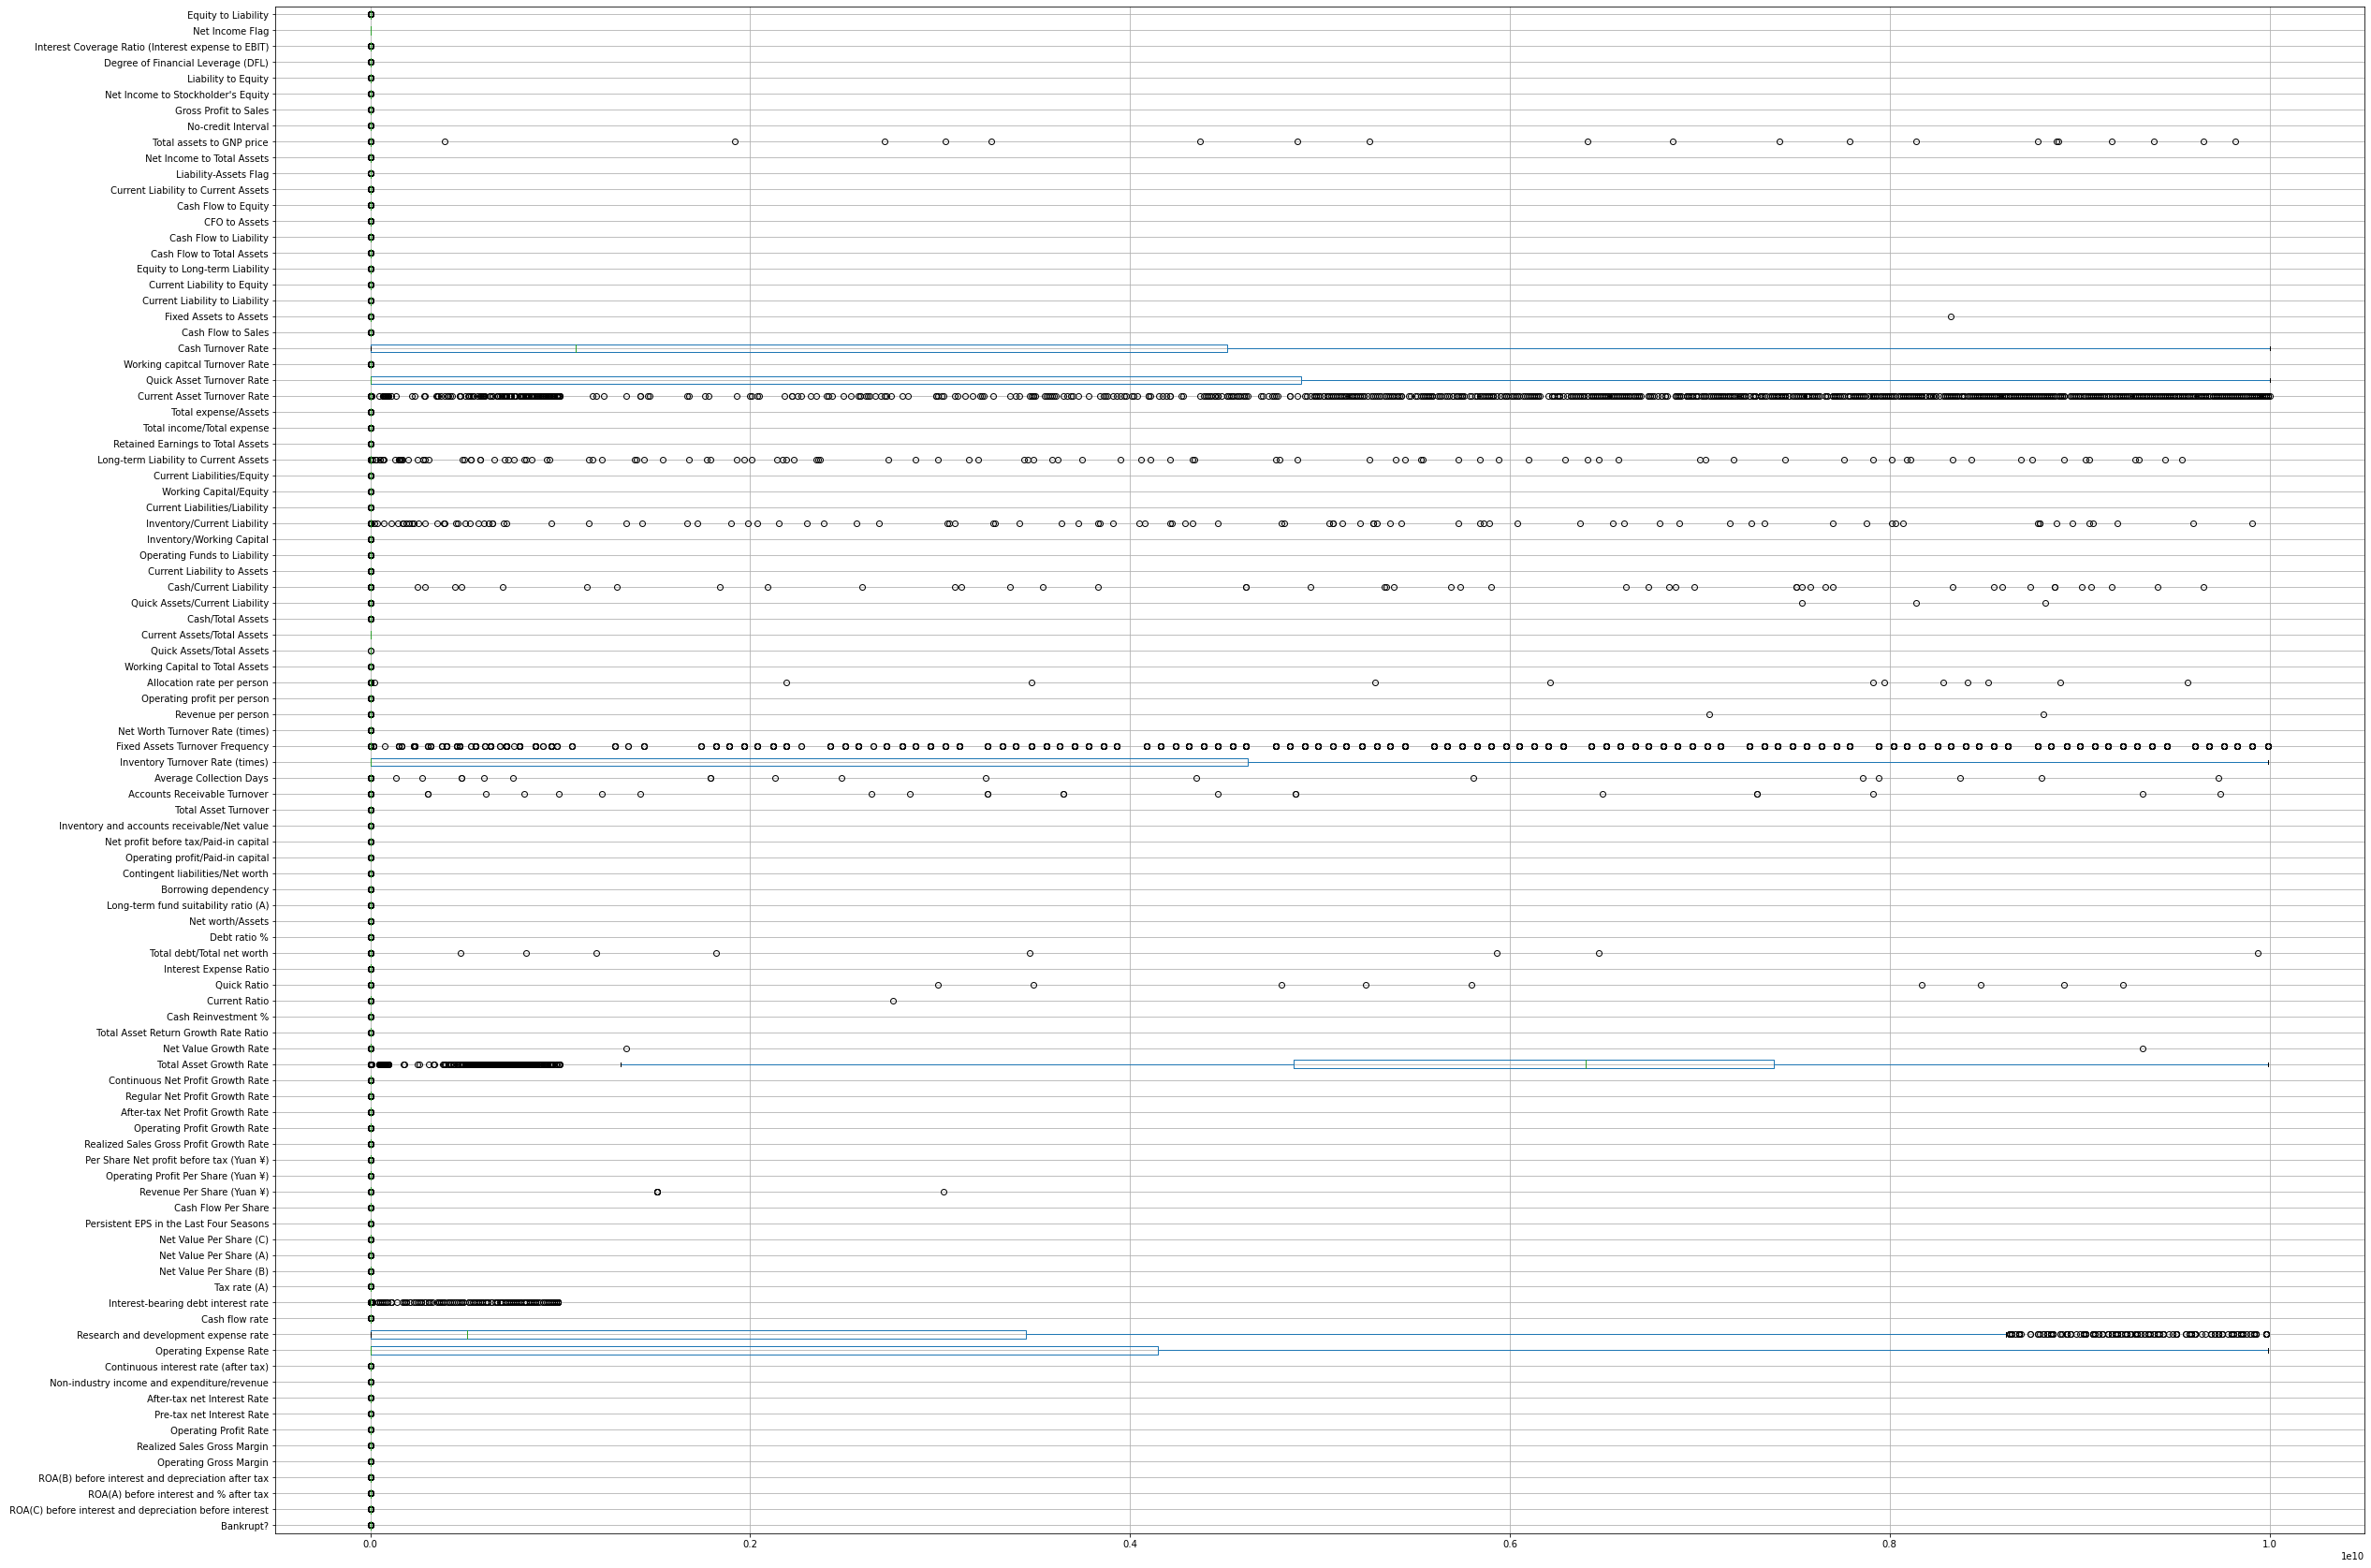

In [26]:
train = pd.read_csv(INPUT_TRAINING_FILE)
test = pd.read_csv(INPUT_EVALUATION_FILE)

print(train['Bankrupt?'].value_counts())
print(test['Bankrupt?'].value_counts()) 

# Load the dataset and combine it, memorize which row is boundary
training_dataset = train
dataset_boundary = len(training_dataset.index)
evaluation_dataset = test
dataset = pd.concat([training_dataset, evaluation_dataset], axis=0)

# Calculate key statistics from original dataset
original_row_amount = len(dataset.index)
original_features_amount = len(dataset.columns)

# Plot boxplot of the dataset
plt.rcParams["figure.figsize"] = (40,30)
dataset.boxplot(vert=False)
plt.show()

## Preprocess the dataset

In [27]:
# Removes outliers. 2 bankrupt companies and almost 600 non banckrupt onec. 
# Something changed and it does not do this anymore!!!??? 
def outliers_removal(feature, feature_name, dataset):
    q1 = np.percentile(feature, 25)
    q3 = np.percentile(feature, 75)
    iqr = q3 - q1
    fence = iqr * 1.5
    fence_lower = q1 - fence 
    fence_upper = q3 + fence
    outliers = [x for x in feature if x < fence_lower or x > fence_upper]
    dataset = dataset.drop(dataset[(dataset[feature_name] > fence_upper) | (dataset[feature_name] < fence_lower)].index)
    return dataset

# Only remove outliers from train data
for col in train:
    new_train = outliers_removal(train[col], str(col), train)

#Original
display(train['Bankrupt?'].value_counts())
# New
display(new_train['Bankrupt?'].value_counts())

0    5279
1     176
Name: Bankrupt?, dtype: int64

0    4837
1     175
Name: Bankrupt?, dtype: int64

# Make a train/test splitt


In [28]:
y_train = new_train['Bankrupt?']
X_train = new_train.drop(['Bankrupt?'], axis = 1)

y_test = test['Bankrupt?']
X_test = test.drop(['Bankrupt?'], axis = 1)

print(y_train.value_counts())
print(y_test.value_counts()) 

0    4837
1     175
Name: Bankrupt?, dtype: int64
0    1320
1      44
Name: Bankrupt?, dtype: int64


### Additional outlier removal


In [29]:
iso = IsolationForest(contamination=0.3)
yhat = iso.fit_predict(X_train)

# select all rows that are not outliers
mask = yhat != -1
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()
print(X_train.shape, y_train.shape)
X_train, y_train = X_train[mask, :], y_train[mask]
print(X_train.shape, y_train.shape)

(5012, 95) (5012,)
(3508, 95) (3508,)


## Rebalance the data to get it ready for machine learning

## Save the preprocessed dataset

In [30]:
# Separate dataset back to original splits and save it
training_dataset = new_train# dataset.iloc[:dataset_boundary,:]
evaluation_dataset = test#dataset.iloc[dataset_boundary:,:]

training_dataset.to_csv(OUTPUT_TRAINING_FILE, index=False, quoting=csv.QUOTE_ALL)
evaluation_dataset.to_csv(OUTPUT_EVALUATION_FILE, index=False, quoting=csv.QUOTE_ALL)